# Area-Between-Curves (ABC) Measure

This notebook is meant to demonstrate how to use the prototype implementation of the Area-Between-Curves (ABC) transfer measure for the L2M program. The motivation of the ABC transfer measure is to attempt to account for additional aspects of forward transfer beyond the given definition used for the program, such as:
- the effect of pre-training on end performance,
- the effect of pre-training on the rate of performance increase with additional experience, and
- The jumpstart pre-training provides on another task,

and incorporate them into a single value. 

## Definition

We define **ABC Transfer** as follows:

$$
    ABC(T_1, T_2) = \int (P_{T_2 | T_1}(l) - B_{T_2}(l))dl = \int P_{T_2 | T_1}(l)dl - \int B_{T_2}(l)dl
$$

where $T_1$ is the task pre-trained on, and $T_2$ is the task trying to be learned. $P_{T_i| T_j}(l)$ is the performance curve of task $i$ given that it was pre-trained on task $j$, $B_{T_i}$ is some baseline performance of a learning algorithm on task $i$, and $l \in \mathcal{R}$ denotes the $l^{th}$ learning experience (LX) in the training block. 

## Implementation

### Expected data format and baseline performance

Later evaluations in L2M assumed that there would be a set number of tasks for the agent to learn, and that the agent would experience all of them in a single lifetime. Then multiple lifetimes would be ran with different permutations of the tasks. This implementation consumes data from a set of lifetimes (runs), computes a baseline performance for each task by averaging the performance curves of each task ran in the first training block. For example, if there are two lifetimes in which task $T_b$ is trained on first, the baseline performance curve for task $T_b$ will be the average of the two curves, and so on for each task. In cases where the lengths of the curves are different, we cut off the end of the longer curve so they have the same number of LXs. Naturally, *that means there may be tasks for which ABC will not be computed if it was never ran first in the training sequence*. 

### Normalization

In order to facilitate comparability between different environments, tasks, and systems, we normalize the ABC values by the number of LXs in the performance curve (or performance curve segements if examining ABC of a section of the curve). This is accomplished by making the substitution $x = \frac{l}{n}$, where $n$ is the number of LXs in the performance and baseline curves (if their lengths are different, we drop the end of the longer curve to make them the same). The result is

$$
    ABC(T_1, T_2) = \int_{0}^{n} (P_{T_2 | T_1}(l) - B_{T_2}(l))dl 
    = \int_{0}^{n} P_{T_2 | T_1}(l)dl - \int_{0}^{n} B_{T_2}(l)dl \\
    = \int_{0}^{1} \left(P_{T_2 | T_1}\left(nx\right) - B_{T_2}\left(nx\right)\right)dx 
    = \int_{0}^{1} P_{T_2 | T_1}\left(nx\right)dx - \int_{0}^{1} B_{T_2}\left(nx\right)dx. 
$$

## Computation

The computation is accomplished via the Trapzoid Rule using `numpy`'s `trapz` method. 


# Area-Between-Curves (ABC) Measure Example

We provide an example use of the ABC curve computation and plotting using data generated from the Ideal Learner and processed by the L2Metrics package. The primary input is a Pandas DataFrame of the data contained in the feather file produced by L2Metrics. The feather file contains the performance data for each LX of each task.

In [1]:
import os
import pandas as pd

from abc_metric import collect_task_data, mean_task_results, show_task_transfer_info

In [2]:
base_path = os.path.abspath('.')
path_to_data_feather = os.path.join(base_path, 'example_results', 'll_metrics_data.feather')

In [3]:
feather_df = pd.read_feather(path_to_data_feather)
feather_df.head()

,block_num,exp_num,worker_id,block_type,block_subtype,task_name,task_params,exp_status,timestamp,performance,regime_num,performance_raw,performance_smoothed,performance_normalized,run_id
0,0,0,0,test,wake,tc_2,"{""name"": ""TC_2"", ""min_perf"": 2.5, ""max_perf"": ...",complete,20210702T170433.544062,1.0,0,2.5,2.5,1.0,3-high_condensed-1625259873-5291016
1,0,1,0,test,wake,tc_2,"{""name"": ""TC_2"", ""min_perf"": 2.5, ""max_perf"": ...",complete,20210702T170433.556029,1.0,0,2.5,2.5,1.0,3-high_condensed-1625259873-5291016
2,0,2,0,test,wake,tc_2,"{""name"": ""TC_2"", ""min_perf"": 2.5, ""max_perf"": ...",complete,20210702T170433.556029,1.0,0,2.5,2.5,1.0,3-high_condensed-1625259873-5291016
3,0,3,0,test,wake,tc_2,"{""name"": ""TC_2"", ""min_perf"": 2.5, ""max_perf"": ...",complete,20210702T170433.556029,1.0,0,2.5,2.5,1.0,3-high_condensed-1625259873-5291016
4,0,4,0,test,wake,tc_2,"{""name"": ""TC_2"", ""min_perf"": 2.5, ""max_perf"": ...",complete,20210702T170433.556029,1.0,0,2.5,2.5,1.0,3-high_condensed-1625259873-5291016


In [4]:
# Get task information for each lifetime, i.e. the performance curve for the 2nd training task, the task it
#    was pre-trained on (first training task), the ABC transfer, and a matrix of differences of area under the
#    curve values for 4 equally divided sections of the performance and base curves. See method definition for 
#    more detail.

# Note: While the comparisons from one section of the performance curves to another may be provide some insight
#    into transfer, the most intuitive results are on the diagonals of the division matrix, which show ABC 
#    transfer for each division of the performance curves. For example, the first diagonal entry may provide 
#    insight to early jumpstart-like transfer, while the last is more indicative of the benefits of transfer 
#    towards the end of training.
task_information, base_perfs = collect_task_data(feather_df, perf_key='performance_normalized')

# For each individual <task 1>, <task 2> pair, aggregate all data points, and return the mean. In other words,
#    return only one performance curve, ABC measure, etc, for each unique task pair, by averaging over all 
#    occurances of that pair in the collected data. 
means, counts = mean_task_results(task_information, base_perfs)


vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tc_2 -- Learning task (Task2): tc_1
Number of samples for this task pair (averaged over): 4
Area between curves (normalized by num LXs): 36.09074613332744
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  41.734516832858326, 1:  39.34550908942584, 2:  33.51274605721797, 3:  25.29090477611091
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+--------------------+-------------------+--------------------+-------------------+
| T1\T2 Division Diffs |       T2.D1        |       T2.D2       |       T2.D3        |       T2.D4       |
+----------------------+--------------------+-------------------+--------------------+-------------------+
|        T1.D1         | 41.734516832858326 | 53.07881261067473 | 62.185133450804145 | 66.32010527694932 |
|        T1.D2         

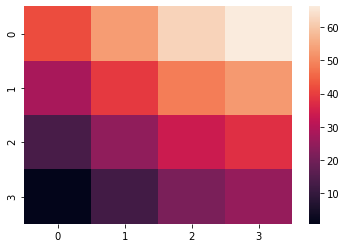

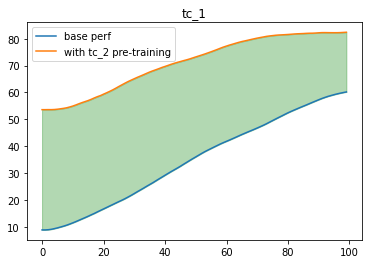

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): ta_2 -- Learning task (Task2): tc_2
Number of samples for this task pair (averaged over): 3
Area between curves (normalized by num LXs): 17.287079218524987
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  19.099283352878633, 1:  16.28218281314263, 2:  16.544302588830643, 3:  15.102206023054991
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+--------------------+--------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1        |       T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+---------------------+--------------------+--------------------+--------------------+
|        T1.D1         |  1

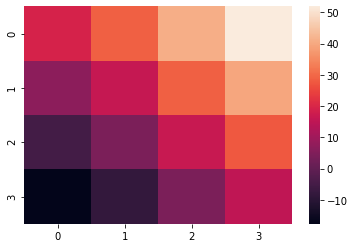

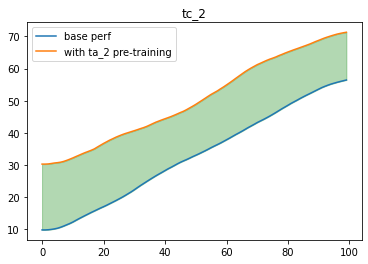

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): ta_1 -- Learning task (Task2): ta_2
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): 47.308352729264776
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  61.24172213371822, 1:  52.06309299079965, 2:  39.79702680238522, 3:  30.383256302316894
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+--------------------+--------------------+-------------------+--------------------+
| T1\T2 Division Diffs |       T2.D1        |       T2.D2        |       T2.D3       |       T2.D4        |
+----------------------+--------------------+--------------------+-------------------+--------------------+
|        T1.D1         | 61.2417221

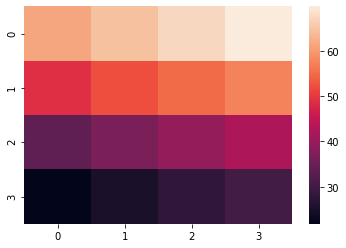

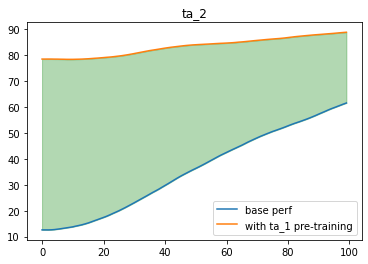

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): ta_1 -- Learning task (Task2): tc_1
Number of samples for this task pair (averaged over): 2
Area between curves (normalized by num LXs): 11.068636244055021
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  4.505779707753682, 1:  11.03403750659956, 2:  13.627709424687893, 3:  13.67030467917435
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+--------------------+---------------------+--------------------+--------------------+
| T1\T2 Division Diffs |       T2.D1        |        T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+--------------------+---------------------+--------------------+--------------------+
|        T1.D1         | 4.50

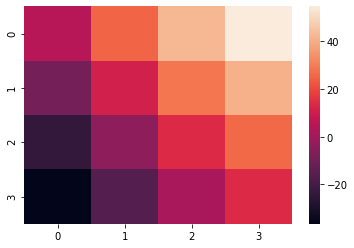

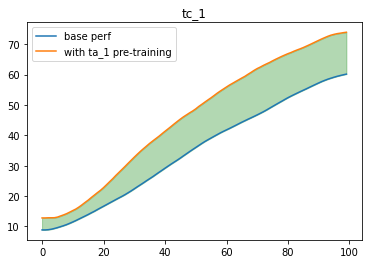

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tc_2 -- Learning task (Task2): ta_2
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): 7.55247062000776
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  3.2654842175018626, 1:  5.487396446654138, 2:  8.578630558841908, 3:  11.988853120062274
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+--------------------+---------------------+--------------------+--------------------+
| T1\T2 Division Diffs |       T2.D1        |        T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+--------------------+---------------------+--------------------+--------------------+
|        T1.D1         | 3.265

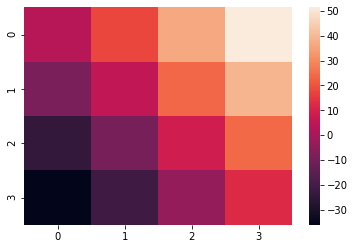

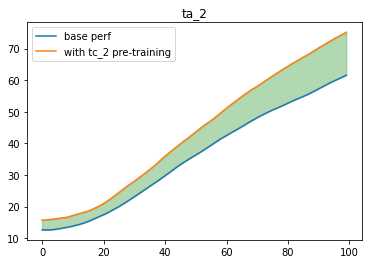

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tb_2 -- Learning task (Task2): ta_1
Number of samples for this task pair (averaged over): 4
Area between curves (normalized by num LXs): 11.038059291453465
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  10.785240812372978, 1:  9.74162052336054, 2:  11.190309529684054, 3:  11.128173600178219
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+---------------------+----------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1        |        T2.D2        |        T2.D3         |       T2.D4        |
+----------------------+---------------------+---------------------+----------------------+--------------------+
|        T1.D1     

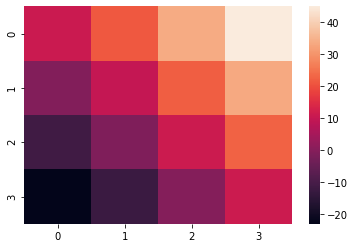

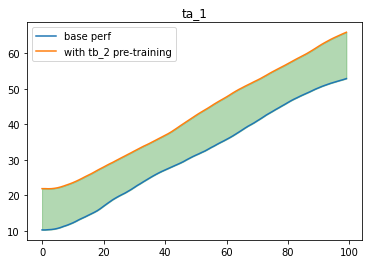

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tc_2 -- Learning task (Task2): ta_1
Number of samples for this task pair (averaged over): 2
Area between curves (normalized by num LXs): -10.511835220250404
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  -4.145792822884268, 1:  -10.94194257072232, 2:  -15.183060032024521, 3:  -10.230335480495805
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+---------------------+---------------------+---------------------+
| T1\T2 Division Diffs |        T2.D1        |        T2.D2        |        T2.D3        |        T2.D4        |
+----------------------+---------------------+---------------------+---------------------+---------------------+
|        T1.D1

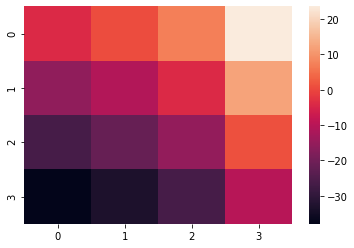

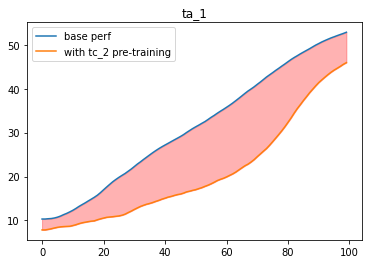

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tc_2 -- Learning task (Task2): tb_1
Number of samples for this task pair (averaged over): 3
Area between curves (normalized by num LXs): 33.205764818403004
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  36.45001161711996, 1:  34.19539608891575, 2:  31.903088655938173, 3:  26.176037588932402
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+--------------------+--------------------+--------------------+--------------------+
| T1\T2 Division Diffs |       T2.D1        |       T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+--------------------+--------------------+--------------------+--------------------+
|        T1.D1         | 36.450

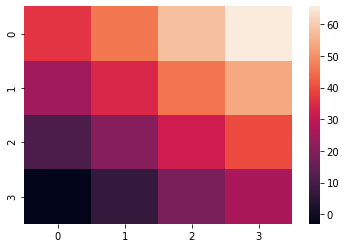

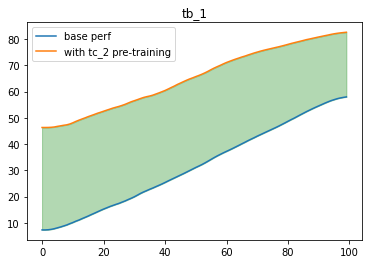

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): ta_2 -- Learning task (Task2): tb_1
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): 2.0985766058370685
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  1.3264653009813756, 1:  0.13516064121689908, 2:  2.710926795168618, 3:  4.001363744584637
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+---------------------+---------------------+-------------------+
| T1\T2 Division Diffs |        T2.D1        |        T2.D2        |        T2.D3        |       T2.D4       |
+----------------------+---------------------+---------------------+---------------------+-------------------+
|        T1.D1         |

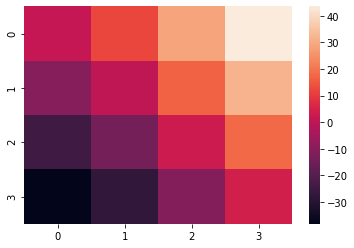

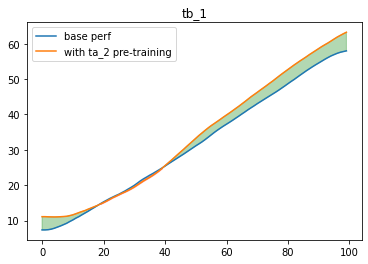

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tb_2 -- Learning task (Task2): tc_2
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): 35.98903771515075
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  42.65223511453841, 1:  38.506533841438674, 2:  33.2425817487942, 3:  25.125922578248705
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+--------------------+--------------------+--------------------+--------------------+
| T1\T2 Division Diffs |       T2.D1        |       T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+--------------------+--------------------+--------------------+--------------------+
|        T1.D1         | 42.65223

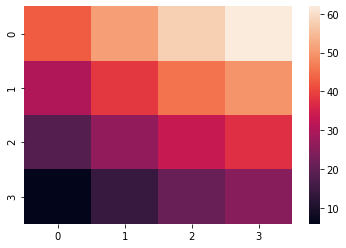

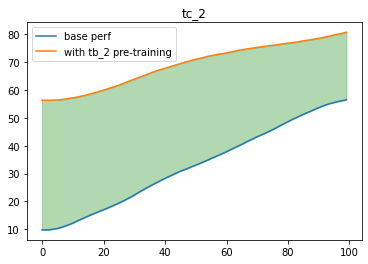

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): ta_2 -- Learning task (Task2): tc_1
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): -13.96928593960622
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  0.6722234181357791, 1:  -10.216221666259164, 2:  -19.799942852231773, 3:  -24.70882901000347
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+---------------------+---------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1        |        T2.D2        |        T2.D3        |       T2.D4        |
+----------------------+---------------------+---------------------+---------------------+--------------------+
|        T1.D1    

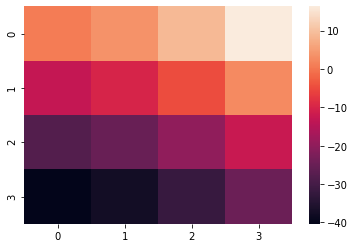

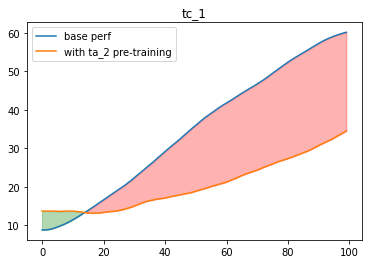

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tc_1 -- Learning task (Task2): tb_1
Number of samples for this task pair (averaged over): 2
Area between curves (normalized by num LXs): 47.780274748478845
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  53.72476871947512, 1:  50.65449137059379, 2:  44.47181154379903, 3:  36.37654718222125
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+--------------------+--------------------+--------------------+--------------------+
| T1\T2 Division Diffs |       T2.D1        |       T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+--------------------+--------------------+--------------------+--------------------+
|        T1.D1         | 53.72476

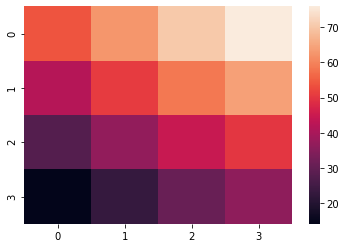

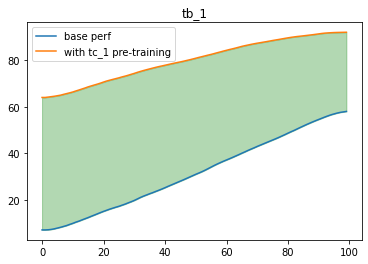

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): ta_2 -- Learning task (Task2): ta_1
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): 45.87037726922523
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  50.04733160570738, 1:  46.4289604857135, 2:  43.646101247349655, 3:  37.795888178799856
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+--------------------+--------------------+--------------------+--------------------+
| T1\T2 Division Diffs |       T2.D1        |       T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+--------------------+--------------------+--------------------+--------------------+
|        T1.D1         | 50.04733

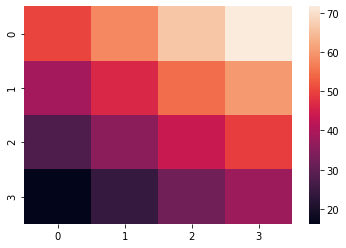

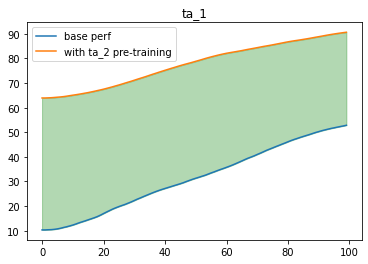

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): ta_1 -- Learning task (Task2): tb_1
Number of samples for this task pair (averaged over): 3
Area between curves (normalized by num LXs): 7.584967452912516
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  5.349498523948067, 1:  5.516490044741368, 2:  7.969086309161061, 3:  10.574985356135327
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+--------------------+--------------------+--------------------+--------------------+
| T1\T2 Division Diffs |       T2.D1        |       T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+--------------------+--------------------+--------------------+--------------------+
|        T1.D1         | 5.349498

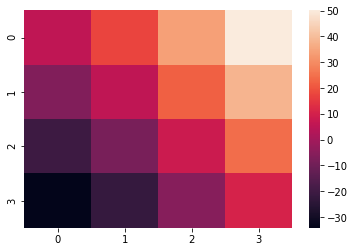

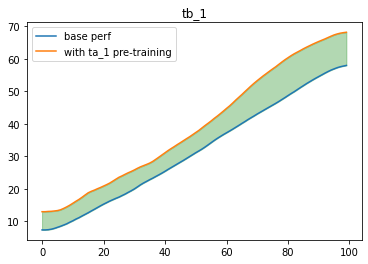

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tb_1 -- Learning task (Task2): ta_2
Number of samples for this task pair (averaged over): 3
Area between curves (normalized by num LXs): 4.543194242938523
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  0.2132439970647718, 1:  5.8063391875389465, 2:  6.514738994584761, 3:  4.958583669447106
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+---------------------+---------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1        |        T2.D2        |        T2.D3        |       T2.D4        |
+----------------------+---------------------+---------------------+---------------------+--------------------+
|        T1.D1         

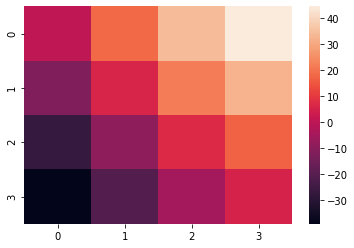

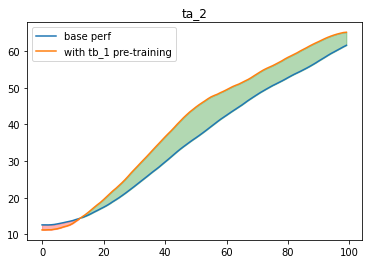

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tc_1 -- Learning task (Task2): ta_1
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): 13.089316785591938
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  14.486409840668253, 1:  9.408980928519178, 2:  11.658794509977334, 3:  15.400547661997194
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+---------------------+--------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1        |        T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+---------------------+---------------------+--------------------+--------------------+
|        T1.D1         |

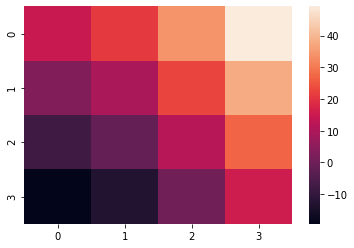

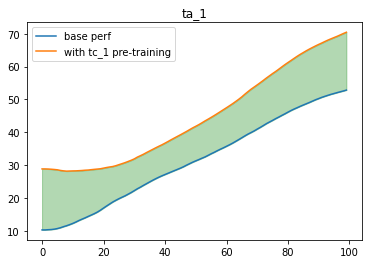

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tc_1 -- Learning task (Task2): ta_2
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): -1.5170327266337518
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  0.823821975970537, 1:  -0.6197413651693502, 2:  -2.6958392795523025, 3:  -3.3883868855058665
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+---------------------+---------------------+---------------------+
| T1\T2 Division Diffs |        T2.D1        |        T2.D2        |        T2.D3        |        T2.D4        |
+----------------------+---------------------+---------------------+---------------------+---------------------+
|        T1.D1

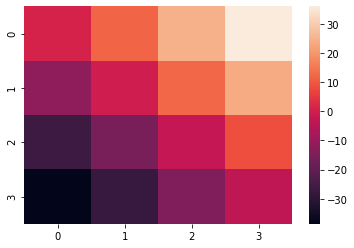

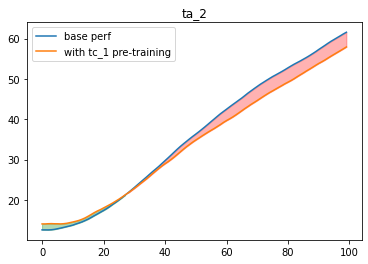

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tc_1 -- Learning task (Task2): tb_2
Number of samples for this task pair (averaged over): 5
Area between curves (normalized by num LXs): 23.91442143588963
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  31.643032052689602, 1:  27.71390238648312, 2:  20.596004403803242, 3:  12.716421026726367
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+--------------------+--------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1        |       T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+---------------------+--------------------+--------------------+--------------------+
|        T1.D1         |  31

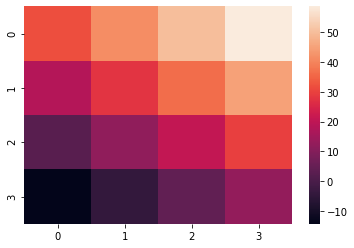

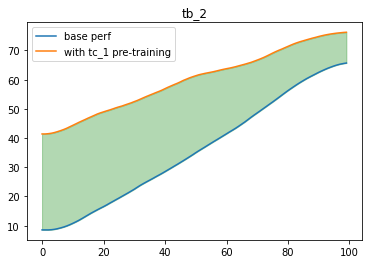

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tb_1 -- Learning task (Task2): ta_1
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): -0.4481519671300324
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  2.8466148474416197, 1:  -3.841083474844652, 2:  -2.774848165477799, 3:  2.2688745071844636
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+---------------------+---------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1        |        T2.D2        |        T2.D3        |       T2.D4        |
+----------------------+---------------------+---------------------+---------------------+--------------------+
|        T1.D1     

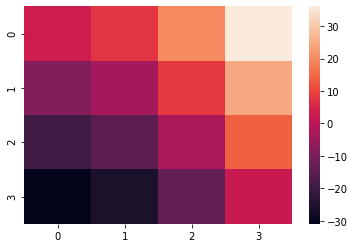

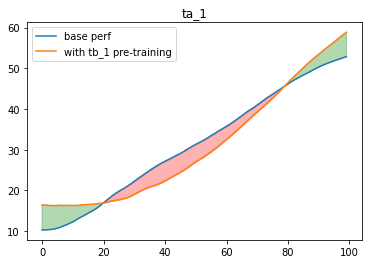

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tb_1 -- Learning task (Task2): tb_2
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): 14.823144643571707
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  16.074902654438787, 1:  8.305365855470185, 2:  17.756019035156157, 3:  15.347776518166725
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+---------------------+--------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1        |        T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+---------------------+---------------------+--------------------+--------------------+
|        T1.D1         |

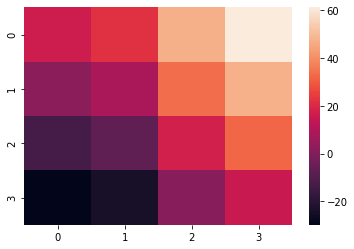

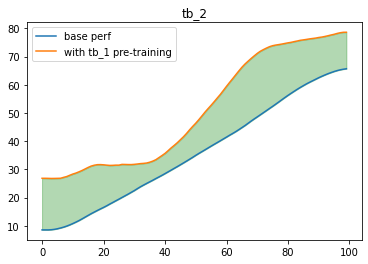

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tb_2 -- Learning task (Task2): tb_1
Number of samples for this task pair (averaged over): 2
Area between curves (normalized by num LXs): 14.830376939047186
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  11.807129527748238, 1:  17.647242806673525, 2:  16.571736090666416, 3:  11.324163403453596
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+----------------------+--------------------+--------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1         |       T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+----------------------+--------------------+--------------------+--------------------+
|        T1.D1         

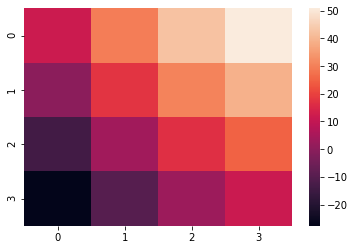

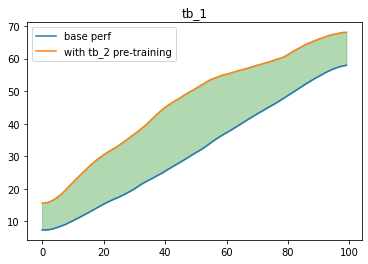

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tb_2 -- Learning task (Task2): ta_2
Number of samples for this task pair (averaged over): 2
Area between curves (normalized by num LXs): 21.026389061287006
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  13.768161966742072, 1:  23.782769543883887, 2:  24.427521622137526, 3:  19.296001060924404
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+--------------------+--------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1        |       T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+---------------------+--------------------+--------------------+--------------------+
|        T1.D1         |  

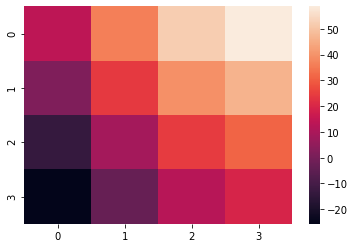

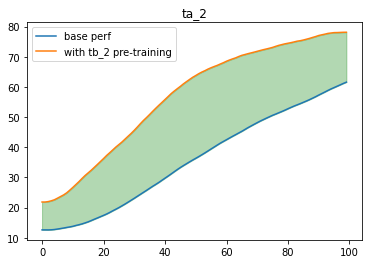

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tb_2 -- Learning task (Task2): tc_1
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): -6.904285830018432
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  -4.545656958174179, 1:  -5.767851217559226, 2:  -6.93031730167165, 3:  -9.604948809710109
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+---------------------+-------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1        |        T2.D2        |       T2.D3       |       T2.D4        |
+----------------------+---------------------+---------------------+-------------------+--------------------+
|        T1.D1         |  -

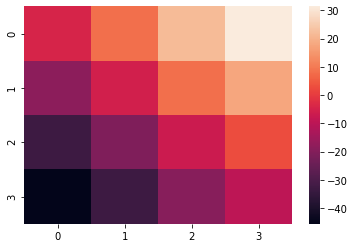

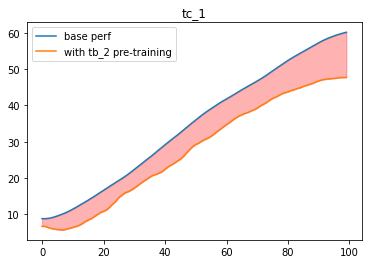

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tc_2 -- Learning task (Task2): tb_2
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): 36.13809523773724
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  43.562761880846594, 1:  41.48481691630888, 2:  32.982306909947326, 3:  21.987951199981765
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+--------------------+--------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1        |       T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+---------------------+--------------------+--------------------+--------------------+
|        T1.D1         |  43

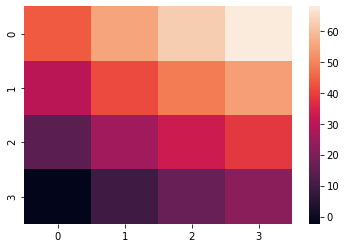

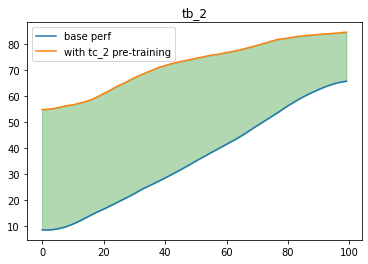

----------------------------------------------------------------------------------------



vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Pre-train task (Task1): tb_1 -- Learning task (Task2): tc_2
Number of samples for this task pair (averaged over): 1
Area between curves (normalized by num LXs): 11.900794756413635
Division matrix diagonal values +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0:  12.347962025496447, 1:  14.976611866108627, 2:  13.587538637348139, 3:  4.995653420725013
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+----------------------+---------------------+--------------------+--------------------+--------------------+
| T1\T2 Division Diffs |        T2.D1        |       T2.D2        |       T2.D3        |       T2.D4        |
+----------------------+---------------------+--------------------+--------------------+--------------------+
|        T1.D1         |  1

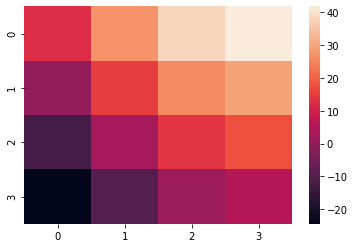

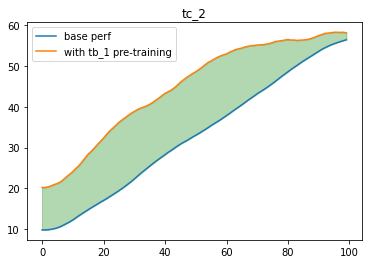

----------------------------------------------------------------------------------------




In [5]:
# Report the ABC measure results for each task pair. Optionally printing the full matrix of differences between
#   areas under the curve for each division, a heat map of that table, and plot the baseline and performance 
#   curves for <task 2>. The plots also fill the space between the curves with green for postive contributions
#   (so, positive ABC), and red for negative ones.
show_task_transfer_info(means, counts, print_table=True, plots=True)